<a href="https://colab.research.google.com/github/zmohaveri/IVT-ActiveLearning/blob/main/IVT_dispendix_analysis_latest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#import

In [2]:
import numpy as np
import pandas as pd
%matplotlib notebook
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from math import sqrt
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from collections import OrderedDict 
import tensorflow as tf
from sklearn.model_selection import train_test_split
import datetime as tm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from itertools import combinations 
from string import ascii_uppercase as alphabets
import random
import glob
import os
from tensorflow import keras
import tensorflow as tf

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
#from tensorflow.keras.activations import gelu
plt.clf()
from keras import backend as K

<IPython.core.display.Javascript object>

In [4]:
%matplotlib inline

#Import and clean the data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##get all data and build dataset

In [6]:
def extract_slopes(data_path, fitting_range=(0,1900)):
  df = pd.read_excel(data_path,header=11).drop(columns='Time [s]')
  df['Unnamed: 0'] = df['Unnamed: 0'].astype(str) + df['Unnamed: 1'].astype(str)
  df = df.drop(columns='Unnamed: 1')
  df.rename(columns={"Unnamed: 0": "well_name"}, inplace='True')

  time = df.keys()[1:].to_numpy()
  n_samples = len(df)

  fit_df = fit_line_to_range(df,fitting_range,time)

  return fit_df


def fit_line_to_range(df,fitting_range: tuple,time):
  fitting_range_index = (fitting_range[0]//time[1],fitting_range[1]//time[1])
  time_interval = time[fitting_range_index[0] : fitting_range_index[1]]
  size = len(df)
  fit_df = pd.DataFrame(columns=['well_name','slopes','intercepts'])
  for i in range(size):
    fit = linregress(time_interval.astype(float), df.loc[i][fitting_range_index[0]+1 : fitting_range_index[1]+1].to_numpy().astype(float))
    slope = fit[0]#slope
    intercept = fit[1]
    name = df['well_name'][i]
    fit_df.loc[i] = [name, slope, intercept]

  return fit_df


In [7]:
def stretch_interval(x1,min1,max1,min2,max2):
  length1 = max1-min1
  length2 = max2-min2
  x = x1 - min1 #move min to zero
  x2 = x * (length2/length1) #stretch
  x2 = x2 + min2
  return x2


def normalize(a,max_real,min_real):
  '''
  normalize between -1 & 1
  '''
  return stretch_interval(a,max_real,min_real,-1,1)


'''def normalize_array(arr,normalization_factors):
  nor_arr = np.empty(arr.shape)
  assert arr.shape[1]==len(normalization_factors)
  for i,factors in enumerate(normalization_factors):
    nor_arr[:,i] = normalize(arr[:,i],factors[0],factors[1])
  return nor_arr
'''
def normalize_2d_array(arr,max_norm,min_norm):
  '''
  We're normalizing each column (concentration of each element) differently, as they can contain very different value ranges
  '''
  n_element = arr.shape[1]
  nor_arr = np.empty(arr.shape)
  for i in range(arr.shape[1]):
    max_real = np.max(arr[:,i])
    min_real = np.min(arr[:,i])
    nor_arr = stretch_interval(arr,min_real,max_real,min_norm,max_norm)
  return nor_arr

'''def undo_normalize_single(b,max,min):
  #b=(2*(a-min)/(max-min))-1
  a = ((b+1)*(max-min)/2) + min
  return (a-min)/(max-min)
'''

def undo_normalize_point(point,min_norm,max_norm,normalization_factors):
  real_point=np.empty(point.shape)
  for i,x in enumerate(point):
    max_real,min_real = normalization_factors[i] #max and min before normalization
    real_point[i] = stretch_interval(point[i],max_norm,min_norm,max_real,min_real)
  return real_point

def undo_normalize(arr,min,max,normalization_factors):
  for i in range(arr.shape[0]):
    arr[i] = undo_normalize_point(arr[i],normalization_factors)
  return arr


def build_dataset(main_path='/content/drive/MyDrive/Thesis/IVT/dispendix/data/**',fitting_range=(0,1900)):
  dataset_df = pd.DataFrame()   #(columns=['well_name',	'spermidine',	'template',	'mgcl2',	'rntp','slopes','intercepts'])
  for folder in glob.iglob(main_path):
    if os.path.isdir(folder): 
      data_df, scanning_labels  = extract_iteration_data(folder,fitting_range)
      dataset_df = dataset_df.append(data_df.drop(columns='well_name'))
  data_with_rep = dataset_df.copy()

  #groupby
  dataset_df = dataset_df.groupby(scanning_labels).mean()
  return dataset_df, data_with_rep,scanning_labels


def extract_iteration_data(folder_path,fitting_range=(0,1900)):
  for filepath in glob.iglob(folder_path+'/*concentrations.csv'):
    df = pd.read_csv(filepath)
    columns = df.columns.tolist() 
    cols_to_use = columns[:len(columns)-1] # drop the last column
    concentrations_df = pd.read_csv(filepath, usecols=cols_to_use)

  for filepath in glob.iglob(folder_path+'/*Measurements.xlsx'):
    fit_df = extract_slopes(filepath,fitting_range)
    

  data_df = pd.merge(concentrations_df, fit_df, on='well_name')
  scanning_labels = concentrations_df.keys().drop('well_name').tolist()

  return data_df , scanning_labels

In [8]:
dataset_df, data_with_rep, scanning_labels = build_dataset()

In [9]:
dataset_df

,,,,slopes,intercepts
spermidine,template,mgcl2,rntp,,
0.02152876833142303,95.23207767186518,143.10464180984184,0.9847087691706968,0.002492,682.381818
0.062337550982015655,153.91264330762155,78.4861265671817,4.28212905484041,4.713098,-186.809091
0.11623389002402451,16.136738422476515,165.70020862077715,2.7098979688052776,-0.017222,651.100000
0.1183816784710423,31.136445856774113,41.473296536343476,2.1230639941471594,3.971077,461.427273
0.17560331533827356,193.75605594796642,183.8144310633305,3.1100230728395157,-0.016919,676.754545
...,...,...,...,...,...
9.64975547797833,62.32946278285184,56.52436226041098,3.0662172289335548,1.109663,418.372727
9.861589921454165,108.14719435549787,10.66563066736862,2.724431365412825,2.714966,903.727273
9.891616974582526,154.21956804045206,108.0123561522101,3.5129162575956836,0.178956,656.445455


In [85]:
scanning_labels_units = ['uM','nM','uM','uM']

In [10]:
dataset_x = np.array([[float(x) for x in row] for row in dataset_df.index.values]) #This is just to get an array out of df, because index values are returned as tuples of strings instead of list of floats.
#dataset_x  = np.array(dataset_df)[:,:-2].astype(float)
dataset_x.shape

(192, 4)

In [11]:
dataset_x.mean(axis=0)

array([ 3.88364046, 92.3669459 , 79.59673207,  2.47997826])

In [12]:
dataset_y = dataset_df['intercepts'].to_numpy()
dataset_y = normalize(dataset_y,np.max(dataset_y),np.min(dataset_y))
dataset_y.shape

(192,)

In [13]:
x = np.copy(dataset_x) #will be normalized
y = np.copy(dataset_y)

#normalizing the dataset
normalization_factors = []
for i in range(x.shape[1]):
  max = np.max(x[:,i])
  min = np.min(x[:,i])
  x[:,i] = normalize(x[:,i],max,min)
  normalization_factors.append((max,min))

#NN Model

##model

In [57]:
def train_model(x,y,batch_size,input_size,layer_sizes,activations,optimizer,epochs,loss='MeanSquaredError',kernel_regularizer=None):
  assert len(layer_sizes) == len(activations)
  n_layers=len(layer_sizes)

  #train-val-test split
  x_train,x_val,y_train,y_val = train_test_split(x,y,test_size=0.2)
  x_train,x_test,y_train,y_test = train_test_split(x_train,y_train,test_size=0.2)

  #building model
  model = Sequential()
  for i in range(n_layers):
    model.add(Dense(layer_sizes[i],kernel_initializer='random_normal',kernel_regularizer=kernel_regularizer,activation=activations[i],input_shape=(input_size,),name=f'layer{i+1}'))
    if i==range(n_layers): continue
    tf.keras.layers.Dropout(.2)
    input_size = layer_sizes[i] * .2
    

  model.compile(
    optimizer = optimizer,
    loss = loss, #MeanSquaredLogarithmicError
  )

  print(model.summary())

  history = model.fit(x_train,y_train,validation_data=(x_val,y_val),batch_size=batch_size,epochs=epochs)
  loss_history = history.history['loss']
  val_history = history.history['val_loss']

  plt.scatter(x=np.arange(1,epochs+1),y=loss_history,label='train loss')
  plt.scatter(x=np.arange(1,epochs+1),y=val_history,label='validation loss')
  plt.legend()
  loss=model.evaluate(x_test,y_test)
  plt.scatter(x=epochs+1,y=loss)
  plt.show()

  print('test loss: ',loss)



  return model
  

Streaming output truncated to the last 5000 lines.
13/13 [==============================] - 0s 8ms/step - loss: 0.0695 - val_loss: 0.0331
Epoch 1502/4000
13/13 [==============================] - 0s 8ms/step - loss: 0.0768 - val_loss: 0.0328
Epoch 1503/4000
13/13 [==============================] - 0s 8ms/step - loss: 0.0577 - val_loss: 0.0328
Epoch 1504/4000
13/13 [==============================] - 0s 21ms/step - loss: 0.0456 - val_loss: 0.0327
Epoch 1505/4000
13/13 [==============================] - 0s 8ms/step - loss: 0.0716 - val_loss: 0.0327
Epoch 1506/4000
13/13 [==============================] - 0s 9ms/step - loss: 0.0711 - val_loss: 0.0328
Epoch 1507/4000
13/13 [==============================] - 0s 8ms/step - loss: 0.0613 - val_loss: 0.0327
Epoch 1508/4000
13/13 [==============================] - 0s 8ms/step - loss: 0.0610 - val_loss: 0.0326
Epoch 1509/4000
13/13 [==============================] - 0s 9ms/step - loss: 0.0556 - val_loss: 0.0327
Epoch 1510/4000
13/13 [==============

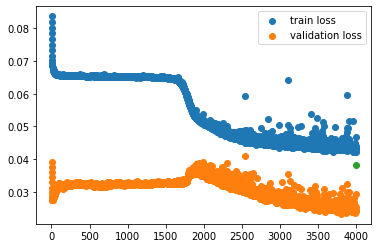

test loss:  0.03826572000980377


In [58]:
layer_sizes = [12,10,7,1]
activations = ['swish','swish','swish','swish']
opt = Adam(learning_rate=0.0008)
reg = tf.keras.regularizers.l2(l2=0.000365)
model = train_model(x,y,batch_size=10,input_size=4,layer_sizes=layer_sizes,activations=activations,optimizer=opt,epochs=4000,kernel_regularizer=reg)

###debugging the model

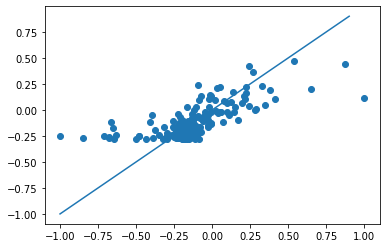

In [59]:
modeled = model.predict_on_batch(x)
y = y.reshape((y.flatten().shape[0],1))
plt.scatter(dataset_y,modeled)
plt.plot(np.arange(-1,1,.1),np.arange(-1,1,.1))
plt.show()

####layer outputs

In [ ]:
outputs = []

for layer in model.layers:
    print(layer.name)
    layer_function = K.function([model.layers[0].input],[layer.output])
    layer_output = layer_function([dataset_x[:10]])[0]
    outputs.append(layer_output)
    print(layer_output)
    #keras_function = K.function([model.input[0]], [layer.output])
    #outputs.append(keras_function([dataset_x, 1]))
print(outputs)

'''
def calc_error(inp, out):
  keras_function = K.function([model.layers[0].input], [model.layers[-1].output])
  res_train = keras_function([inp])[0]
  print(res_train.shape)
  print(y_train.shape)
  err_train = keras_function([inp])[0] - out.reshape((out.shape[0], 1))
  err_msq_train = np.mean(err_train**2)
  print((err_train**2).shape)
  print(err_msq_train)

  return err_msq_train

print(calc_error(x_test, y_test))
# train_error = np.sum((keras_function([x_train])[0] - y_train)**2)
# print(train_error)
'''

layer1
[[ 1.67036911e+02 -2.13326201e-01 -0.00000000e+00  8.29000026e-02
   1.98175645e+00 -1.30068838e-31 -6.70364052e-02 -1.31499034e-10
  -2.74020493e-01  1.25441677e-03]
 [ 1.13724014e+02 -8.88743699e-02 -9.64813047e-35  2.62962669e-01
   5.70446908e-01 -1.13584588e-32 -3.61848921e-02  7.69071732e+01
  -1.20448589e-01  1.16845826e-03]
 [ 1.77216965e+02 -1.42697677e-01 -0.00000000e+00 -5.97067401e-02
   2.78036332e+00 -5.65325442e-21 -7.75251016e-02 -0.00000000e+00
   3.28901142e-01  1.02303526e-03]
 [ 5.11132278e+01 -2.39995763e-01 -1.86866983e-17  3.10467985e-02
   4.04575944e-01 -7.18369364e-09 -2.05672216e-02 -7.24597499e-02
  -1.94902241e-01  3.81356920e-04]
 [ 2.28992233e+02 -4.40882817e-02 -0.00000000e+00  2.69739479e-01
   2.38940859e+00 -0.00000000e+00 -8.28786865e-02  3.06458607e+01
  -9.36532840e-02  1.95561256e-03]
 [ 2.00688919e+02 -1.89929292e-01 -0.00000000e+00  8.93083140e-02
   2.53013301e+00 -7.76481389e-36 -7.86781013e-02 -8.51689670e-16
  -2.70277083e-01  1.47455

'\ndef calc_error(inp, out):\n  keras_function = K.function([model.layers[0].input], [model.layers[-1].output])\n  res_train = keras_function([inp])[0]\n  print(res_train.shape)\n  print(y_train.shape)\n  err_train = keras_function([inp])[0] - out.reshape((out.shape[0], 1))\n  err_msq_train = np.mean(err_train**2)\n  print((err_train**2).shape)\n  print(err_msq_train)\n\n  return err_msq_train\n\nprint(calc_error(x_test, y_test))\n# train_error = np.sum((keras_function([x_train])[0] - y_train)**2)\n# print(train_error)\n'

#Using the trained model to find the maximum Yield

##Generating random grid

In [60]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [61]:
def random_points_in_range(n,ranges):
  points = np.empty((n,len(ranges)))
  for i,element in enumerate(ranges):
    start=np.min(element)
    interval=abs(element[1]-element[0])
    #rand_check = np.random.rand(n)
    #randoms = ( rand_check*interval ) + start
    low=start
    high=start+interval
    randoms = np.random.uniform(low=low,high=high,size=n)
    points[:,i] = randoms.T
  return points

In [113]:
def random_survey(run_n_times,n_param=4,size=100000,plot_scatter=False,plot_hist=False,print_max=False,print_all=False,plot_2by2=False,extrapol=2):
  n = run_n_times
  maxes = np.empty((n,2,n_param))
  for i in range(n):
    random_grid = random_points_in_range(size,[(-1,extrapol),(-1,extrapol),(-1,extrapol),(-1,extrapol)]) #our actual points were normalized between -1 & 1
    preds = model.predict_on_batch(random_grid)
    preds_h = np.array(list(preds))
    max_array_index = np.argmax(preds)
    max = preds[max_array_index]
    max_index = undo_normalize_point(random_grid[max_array_index],-1,1,normalization_factors)
    maxes[i,0] = max_index #undo-normalized
    maxes[i,1] = max
    if print_max: print(max,max_index)
    if print_all: print(preds[:])

    if plot_2by2:
      for j in range(n_param):
        a=1

  if plot_hist :
    for j in range(n_param):
      plt.subplot(221+j)
      plt.hist(maxes[:,0,j],20)
      plt.title(scanning_labels[j]+scanning_labels_units[j])
    plt.show()

  if plot_scatter:
    for i in range(n_param):
      plt.subplot(221+i)
      plt.scatter(maxes[:,0,i],maxes[:,1,0],c=maxes[:,1,0])
      plt.title(f'{scanning_labels[i]} ({scanning_labels_units[i]})')
      plt.grid(True,which='both')
      plt.subplots_adjust(top = 2, right=2)
    plt.show()

  '''avg =  np.average(maxes,axis=0)
  print('avg:\n',avg)
  print('variance:\n',np.var(maxes,axis=0))
  print('undo-normalized:\n',undo_normalize_point(avg,-1,1,normalization_factors))
  '''

  return maxes

In [23]:
dataset_x.mean(axis=0)

array([ 3.88364046, 92.3669459 , 79.59673207,  2.47997826])

In [25]:
 x.mean(axis=0)

array([0.22505588, 0.06518813, 0.21487614, 0.00511542])

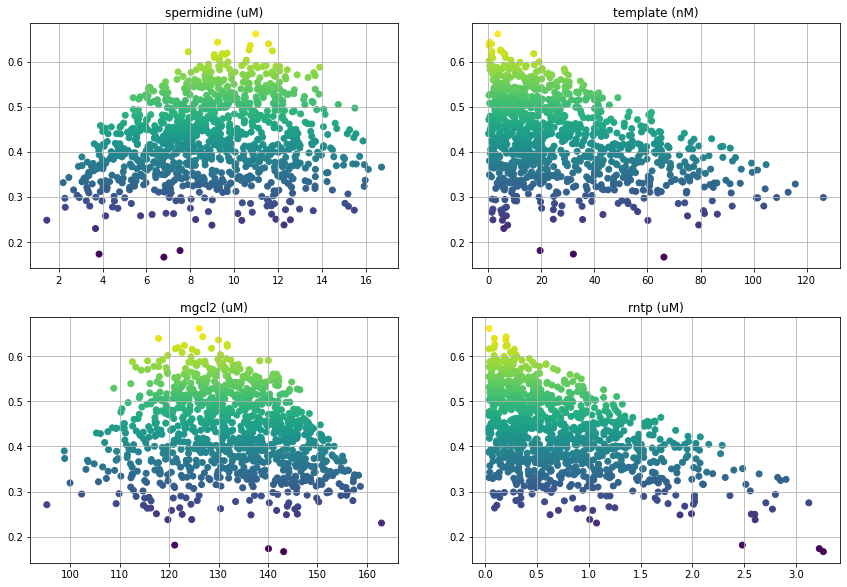

In [118]:
maxes = random_survey(1000,plot_scatter=True,extrapol=10)

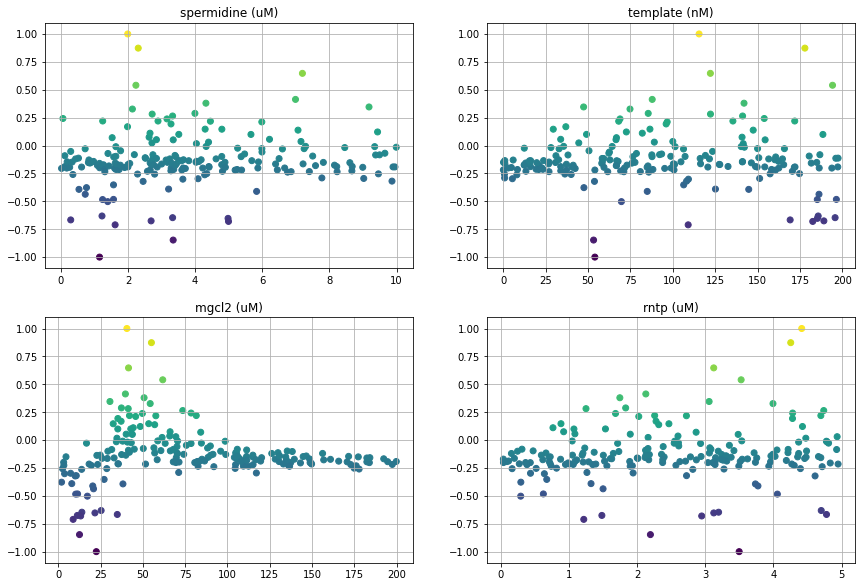

In [112]:
for i in range(4):
  plt.subplot(221+i)
  plt.scatter(dataset_x[:,i],dataset_y,c=dataset_y)
  plt.title(f'{scanning_labels[i]} ({scanning_labels_units[i]})')
  plt.grid(True,which='both')
  plt.subplots_adjust(top = 2, right=2)
plt.show()

In [84]:
print(np.average(x,axis=0))
print(np.max(x,axis=0))
print(np.min(x,axis=0))

print(np.average(dataset_x,axis=0))
print(np.max(dataset_x,axis=0))
print(np.min(dataset_x,axis=0))

[0.22505588 0.06518813 0.21487614 0.00511542]
[1. 1. 1. 1.]
[-1. -1. -1. -1.]
[ 3.88364046 92.3669459  79.59673207  2.47997826]
[  9.98898731 197.44289591 199.71733693   4.94960927]
[0.02152877 0.15201963 1.96778712 0.03548505]


####debugging stuff

In [ ]:
a = model.predict_on_batch(x)
for i,pred in enumerate(a):
  print(pred,y[i])

[0.21209033] [0.20504451]
[-0.08328594] [-0.2423683]
[0.21226448] [0.18894231]
[0.00175132] [0.09130898]
[0.20439792] [0.2021479]
[0.19268253] [0.14601715]
[0.19712238] [0.19517542]
[0.02706656] [0.05278255]
[0.37712154] [0.66667369]
[0.15392917] [0.14779536]
[0.21010052] [0.25966846]
[0.05247372] [0.1200833]
[0.09185523] [0.11293768]
[0.22290906] [0.39290352]
[0.1670756] [0.1929433]
[0.01463881] [0.0293148]
[0.43918213] [0.43676459]
[0.48986226] [0.37737222]
[0.08252843] [0.15218943]
[0.06859517] [0.12896969]
[0.02890421] [0.15640567]
[0.04314153] [0.15490354]
[0.1728429] [0.1424654]
[0.21748416] [0.177777]
[0.08205456] [0.15994338]
[0.2944519] [1.]
[0.54644483] [0.19936359]
[0.48836857] [0.63143696]
[0.16081777] [0.17641994]
[0.65357304] [0.48423355]
[0.0027351] [-0.21969139]
[0.20710592] [0.17258742]
[0.16982715] [0.21446437]
[0.12426583] [0.23502147]
[0.19111751] [0.50275038]
[0.12146845] [0.07118708]
[0.07011903] [0.18274196]
[0.0348584] [-0.07043367]
[0.54564625] [0.48275483]
[0.

In [ ]:
np.set_printoptions(suppress=True)
print(x)


[[-1.      -0.03614  0.42743 -0.61368]
 [-0.99181  0.55872 -0.22611  0.72834]
 [-0.981   -0.83796  0.65596  0.08846]
 [-0.98057 -0.6859  -0.60045 -0.15038]
 [-0.96908  0.96263  0.83916  0.25131]
 [-0.96674  0.06121  0.71529  0.62348]
 [-0.95147  0.73839  0.82431  0.59631]
 [-0.94528  0.24983 -0.11093  0.04786]
 [-0.94526  0.7136  -0.667    0.93079]
 [-0.93667 -0.72764  0.44353  0.88281]
 [-0.93224 -0.59484  0.77796  0.31817]
 [-0.91638  0.58548 -0.30799 -0.95191]
 [-0.89887  1.       0.29325  0.70056]
 [-0.89598  0.46608 -0.63322  0.50598]
 [-0.8803   0.51645  0.34286  0.05462]
 [-0.85898 -0.66712 -0.38091 -0.31728]
 [-0.85855  0.88589 -0.80902 -0.40435]
 [-0.85104 -0.51876 -1.      -0.89564]
 [-0.8396  -0.68858  0.14351  0.80891]
 [-0.83651 -0.3631  -0.01907  0.30496]
 [-0.83299 -0.86641 -0.31452 -0.15305]
 [-0.82672 -0.84367 -0.12452  0.32322]
 [-0.80863 -0.31461  0.46219  0.59865]
 [-0.7859  -0.78647  0.34351 -0.56202]
 [-0.77306 -0.99124 -0.68603  0.5138 ]
 [-0.77302 -0.4534  -0.79